# <a href="https://colab.research.google.com/github/abhinsuresh/MLTSA_ASuresh/blob/master/HW5/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import pylab as pl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")
mpl.style.use('default')

In [0]:
from google.colab import drive

drive.mount("/content/gdrive")

In [0]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [0]:
!mkdir PLAsTiCC

In [0]:
cd PLAsTiCC

/content/gdrive/My Drive/PLAsTiCC


#Data Acquisition

In [0]:
!wget https://zenodo.org/record/2539456/files/plasticc_train_lightcurves.csv.gz

In [0]:
lcvs = pd.read_csv('plasticc_train_lightcurves.csv.gz')

In [325]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [326]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [327]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".\
      format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [0]:
!wget https://zenodo.org/record/2539456/files/plasticc_train_metadata.csv.gz

In [328]:
metadata = pd.read_csv("plasticc_train_metadata.csv.gz")
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [329]:
metadata.columns

Index(['object_id', 'ra', 'decl', 'ddf_bool', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target',
       'true_target', 'true_submodel', 'true_z', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y'],
      dtype='object')

In [332]:
print("The metadata dataset contains more information for each time series: \
      (time-series, columns)",
      metadata.shape)

The metadata dataset contains more information for each time series:       (time-series, columns) (7848, 26)


In [0]:
norm_band = Normalize(vmin=bands.min(), vmax=bands.max())

##Data Visulaization

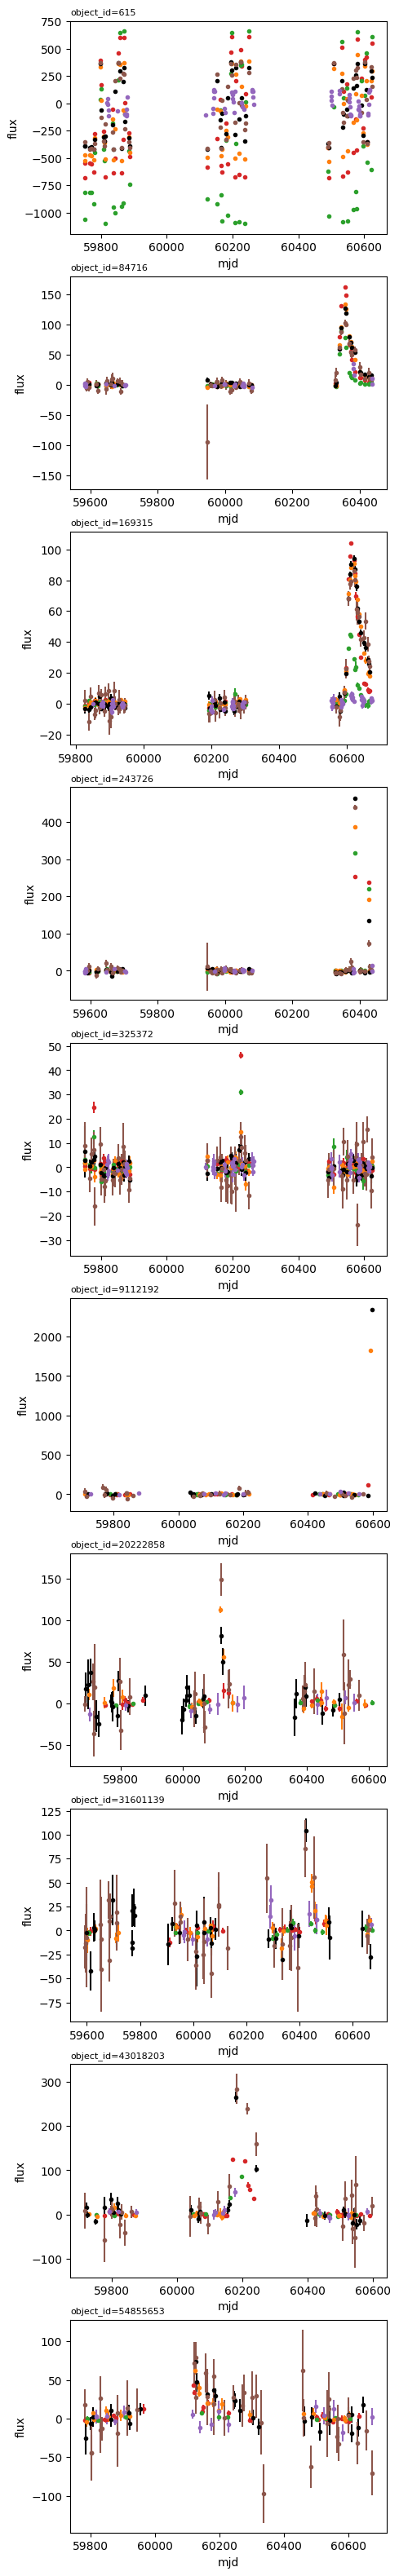

In [0]:
#choose set of object_id
ls = [615, 84716, 169315, 243726, 325372, \
      9112192, 20222858, 31601139, 43018203, \
      54855653]

#colo codes form website
_passbands = OrderedDict([(0,'C4'), (1,'C2'), (2,'C3'),\
                          (3,'C1'), (4,'k'), (5,'C5')])

fig, axs = plt.subplots(10, 1, figsize=(5,40))
for i, ls_i in enumerate(ls):
  axs[i].set_title('object_id='+str(ls_i), loc = 'left',
                   size = 8)
  axs[i].set_xlabel('mjd')
  axs[i].set_ylabel('flux')

  for j in bands:
    axs[i].errorbar(lcvs.loc[lcvs['passband']== j, 'mjd'].\
                    where(lcvs.object_id==ls_i), 
                    lcvs.loc[lcvs['passband']== j, 'flux'].\
                    where(lcvs.object_id==ls_i), 
                    lcvs.loc[lcvs['passband']== j, 'flux_err'].\
                    where(lcvs.object_id==ls_i),
                    fmt = 'o', color = _passbands[j], ms = 3)

Figure 1: This plot shows the flux  corresponding to different bands against modified Julian days, along with errorbars for 10 different objects. Color codes (ultraviolet→'C0', green/blue→'C2', red→'C3', infrared→'C1', z→'k', y→'C5'). The peak in flux for various different objects on different days can be seen in the figure. for  object 84716 there is steep rise in flux and then a gradual decrease. Similar pattern is observed for several other objects.

**==>missing Task 4.1 feature description**

#Feature Extraction

1. Extraction mean and standard deviation of the original lightcurve

In [0]:
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()
stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()

In [0]:
features = means.rename({"flux": "mean"}, axis=1).\
                  merge(stds.rename({"flux": "std"}, axis=1), 
                        left_index=True, right_index=True)

In [336]:
features.head()

mean         std
object_id passband                        
615       0          -3.254554   83.944735
          1        -385.699911  601.787302
          2        -134.146566  455.121346
          3        -121.103501  335.425053
          4         -55.954592  291.803449

2. Normalizing the original lightcurve

In [0]:
# normalize each LC this is very slow. can you make  it faster?
def normed(df):
   return (df - df.mean())/df.std()
       
lcvs['fluxnormed'] = lcvs.groupby(["object_id", "passband"])[['flux']].\
                                  apply(normed)
lcvs['fluxerrnormed'] = lcvs.groupby(["object_id", "passband"])[['flux_err']].\
                                  apply(normed)

Visulazing few of the normalized lightcurves

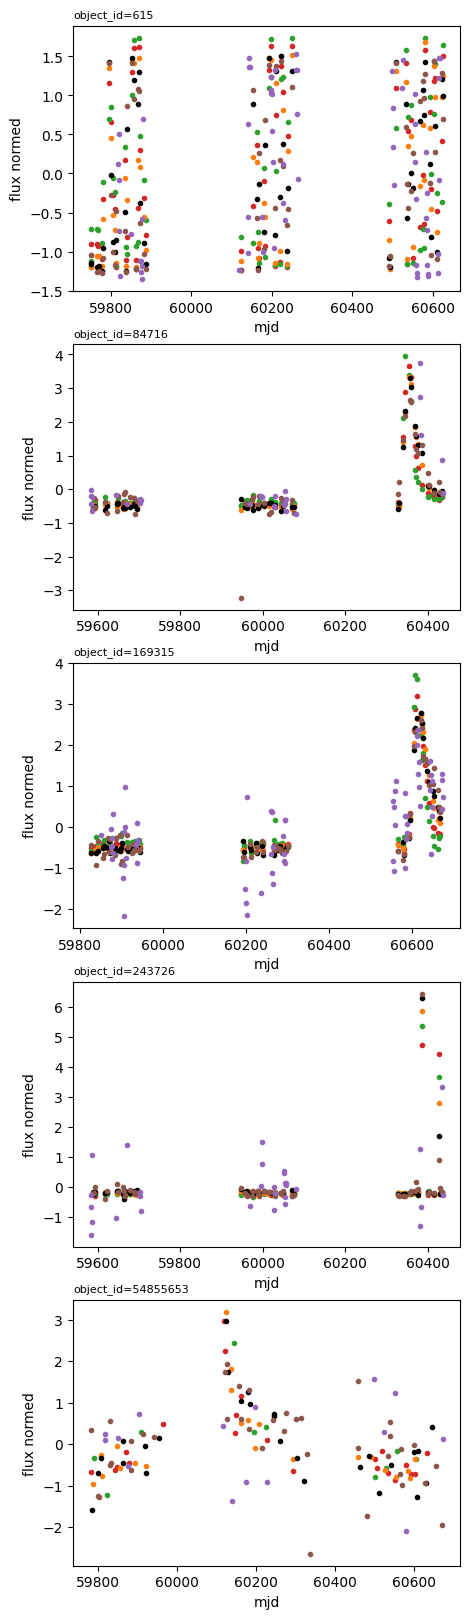

In [338]:
ls = [615, 84716, 169315, 243726, 54855653]
fig, axs = plt.subplots(5, 1, figsize=(5,20))
for i, ls_i in enumerate(ls):
  axs[i].set_title('object_id='+str(ls_i), loc = 'left',
                   size = 8)
  axs[i].set_xlabel('mjd')
  axs[i].set_ylabel('flux normed')

  for j in bands:
    axs[i].errorbar(lcvs.loc[lcvs['passband']== j, 'mjd'].\
                    where(lcvs.object_id==ls_i), 
                    lcvs.loc[lcvs['passband']== j, 'fluxnormed'].\
                    where(lcvs.object_id==ls_i),
                    fmt = 'o', color = _passbands[j], ms = 3)

3. Extraction of median and line fit parameters from normalized lightcurve

In [0]:
median = lcvs.groupby(["object_id", "passband"])[["fluxnormed"]].median()
#stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()

In [0]:
features = features.merge(median.rename({"fluxnormed": "median"}, axis=1), 
                        left_index=True, right_index=True)

In [0]:
def slope(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    return pars[0]
def intercept(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    return pars[1]  

features['slope'] = lcvs.groupby(["object_id", "passband"]).\
                                      apply(slope).to_frame()
features['intercept'] = lcvs.groupby(["object_id", "passband"]).\
                                      apply(intercept).to_frame()

In [342]:
features.head()

mean         std    median     slope  intercept
object_id passband                                                       
615       0          -3.254554   83.944735 -0.080537  0.005676  -0.175947
          1        -385.699911  601.787302 -0.170090  0.014032  -0.399902
          2        -134.146566  455.121346 -0.289021  0.017676  -0.503760
          3        -121.103501  335.425053 -0.122434  0.020475  -0.583524
          4         -55.954592  291.803449 -0.163078  0.022343  -0.636786

Table 1: Here I have extracted the mean and standared deviation of the flux for different object according to their color bands. These features are important since they signify averge of flux and their variations. For finding skewness towards we only need to work with normalized data where we have extracted meadian and line fitting parameters

In [0]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])

In [0]:
metadata.set_index('object_id', inplace=True)

4. Adding features from metadata

In [345]:
allfeatures = pd.merge(allfeatures, metadata[["decl", "ddf_bool"]], 
                       on = 'object_id', how = 'right')
allfeatures.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(0, mean)","(0, std)","(0, median)","(0, slope)","(0, intercept)","(1, mean)","(1, std)","(1, median)","(1, slope)","(1, intercept)","(2, mean)","(2, std)","(2, median)","(2, slope)","(2, intercept)","(3, mean)","(3, std)","(3, median)","(3, slope)","(3, intercept)","(4, mean)","(4, std)","(4, median)","(4, slope)","(4, intercept)","(5, mean)","(5, std)","(5, median)","(5, slope)","(5, intercept)",decl,ddf_bool
object_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
615,-3.254554,83.944735,-0.080537,0.005676,-0.175947,-385.699911,601.787302,-0.170090,0.014032,-0.399902,-134.146566,455.121346,-0.289021,0.017676,-0.503760,-121.103501,335.425053,-0.122434,0.020475,-0.583524,-55.954592,291.803449,-0.163078,0.022343,-0.636786,-47.449847,294.779522,-0.129163,0.021319,-0.596932,-61.9438,1
713,-2.720398,7.113509,-0.052914,-0.041433,1.429423,-1.019804,5.712334,0.080189,-0.051648,1.420320,-0.794238,5.770738,0.117188,-0.053887,1.481892,-0.986966,6.450413,0.141552,-0.050983,1.402038,-0.900262,6.406989,0.016870,-0.050464,1.387765,-1.794175,7.094073,-0.094281,-0.037903,1.042343,-27.7844,1
730,-0.048080,1.828872,0.039463,-0.001798,0.063840,0.141057,1.807229,0.016754,0.003167,-0.080770,2.400870,5.559483,-0.343392,0.026905,-0.686084,3.236164,8.191987,-0.314425,0.024491,-0.624531,4.308728,10.710344,-0.308522,0.022552,-0.563811,4.539396,13.332758,-0.149763,0.019612,-0.490299,-6.5796,1
745,1.797523,4.374445,-0.169349,-0.013089,0.464675,5.717394,25.964659,-0.185994,-0.003826,0.105205,9.711532,31.957997,-0.290606,-0.003878,0.106641,14.412924,34.967698,-0.373246,-0.003931,0.108112,13.134436,33.069053,-0.358773,-0.004774,0.131296,10.746138,26.060130,-0.306851,-0.002816,0.076043,-45.5867,1
1124,0.660948,2.360084,-0.033864,0.017117,-0.530614,4.634637,8.107525,-0.429236,0.028666,-0.816982,10.243968,21.319854,-0.438785,0.025384,-0.723449,11.086555,26.270649,-0.383411,0.021342,-0.608237,9.906102,26.865913,-0.303771,0.019736,-0.562470,6.896742,21.434627,-0.229697,0.015555,-0.435534,-63.8237,1


#Our total feature space

In [346]:
print("My feature space is {} features (columns)".\
      format(len(allfeatures.columns)))

My feature space is 32 features (columns)


#Create your train and test set out of the feature matrix and preprocess them to remove correlation by scaling them along the feature axis

In [347]:
# check for NaNs and infinities
print("there are {} NaN and {} infinity entries".format(
 (allfeatures.isna().sum().sum()), np.prod(allfeatures.shape) - 
 (np.isfinite(allfeatures).sum().sum())))

there are 0 NaN and 0 infinity entries


In [348]:
np.isfinite(allfeatures).sum()

(0, mean)         7848
(0, std)          7848
(0, median)       7848
(0, slope)        7848
(0, intercept)    7848
(1, mean)         7848
(1, std)          7848
(1, median)       7848
(1, slope)        7848
(1, intercept)    7848
(2, mean)         7848
(2, std)          7848
(2, median)       7848
(2, slope)        7848
(2, intercept)    7848
(3, mean)         7848
(3, std)          7848
(3, median)       7848
(3, slope)        7848
(3, intercept)    7848
(4, mean)         7848
(4, std)          7848
(4, median)       7848
(4, slope)        7848
(4, intercept)    7848
(5, mean)         7848
(5, std)          7848
(5, median)       7848
(5, slope)        7848
(5, intercept)    7848
decl              7848
ddf_bool          7848
dtype: int64

In [349]:
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna().shape

((7848, 32), (7848, 32))

#Split train-test set

In [0]:
X = allfeatures.iloc[:,:-1]
y = allfeatures.iloc[:,-1]

import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split( X, y, test_size=0.25, random_state=345, shuffle=True)
#remember to use the random state so that your work is reproducible and use a split between 60-40 and 75-25.

#Scale train set and test set

In [351]:
from sklearn import preprocessing
Xtrain_scaled = preprocessing.scale(X_train)
Xtest_scaled = preprocessing.scale(X_test)

print("scaled training data feature mean and standard deviations: ", 
      Xtrain_scaled.mean(axis=0), Xtrain_scaled.std(axis=0))

scaled training data feature mean and standard deviations:  [-2.41434841e-18  4.22510971e-18  2.41434841e-18 -1.20717420e-18
 -6.03587101e-18  1.20717420e-18 -9.65739362e-18  1.17699485e-17
 -2.35398970e-17 -2.29363099e-17  1.20717420e-18  1.08645678e-17
 -4.94941423e-17  2.77650067e-17 -5.43228391e-18  2.41434841e-18
  1.08645678e-17  1.03213394e-16  1.75040259e-17  1.38825033e-17
  2.41434841e-18 -4.82869681e-18 -3.62152261e-18 -1.69004388e-17
 -7.84663232e-18  0.00000000e+00  9.65739362e-18  1.08645678e-17
  1.44860904e-17 -7.24304522e-18 -9.70266265e-17] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]


#Visualize a large dimensional feature space

In [0]:
from sklearn.manifold import TSNE

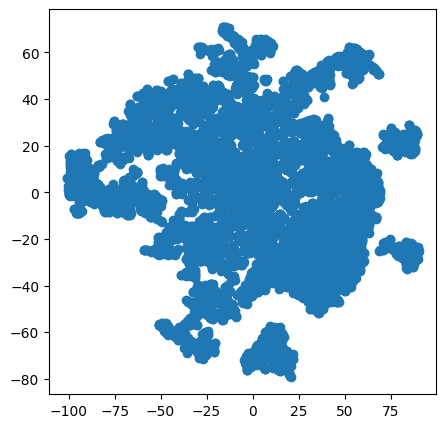

Figure: the 2D projection of the 79-dimensional feature space we created by extracting features from the time series. The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledianpairwise distances existing in the higher dimensional parameter space. How many clusters can you see in this embedding?A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, this is the only cxase in which you are allowed not to label your axes!


In [353]:
X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X)
X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1])
pl.show()
print("Figure: the 2D projection of the 79-dimensional feature space we created by extracting features from the time series. " + 
      "The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: " + 
      "t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledian" + 
      "pairwise distances existing in the higher dimensional parameter space. " + 
      "How many clusters can you see in this embedding?" + 
      "A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, " + 
      "this is the only cxase in which you are allowed not to label your axes!")



To assure that the clusters map to the target variable tho. So we will redo the plot colorcoded by target variable

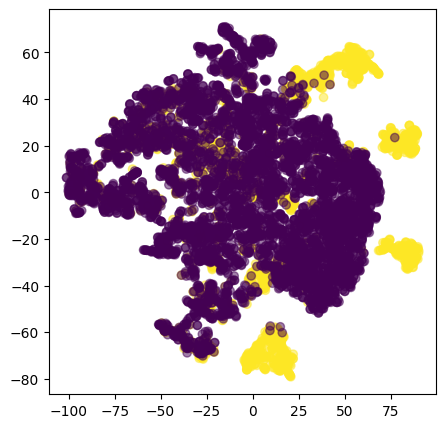

In [354]:
norm_obj= Normalize(vmin=y.min(), vmax=y.max())
len([c for c in pl.cm.RdBu_r(norm_obj(y.values))]), X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1],  
           color=[c for c in pl.cm.viridis(norm_obj(y.values))], alpha=0.5);

Figure: the purity of the sample is not good in the t-SNE projection against the target variable.


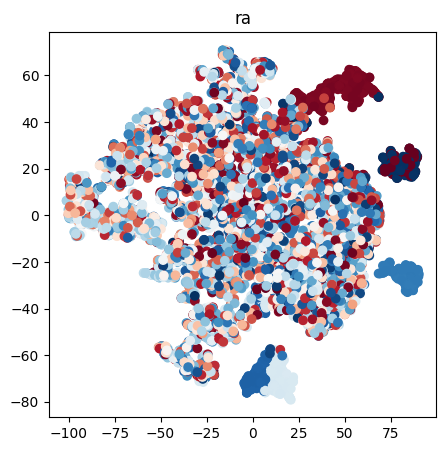

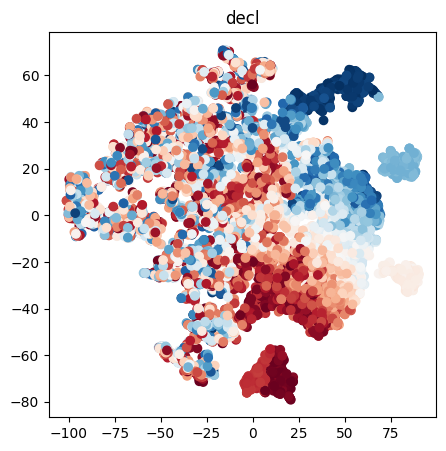

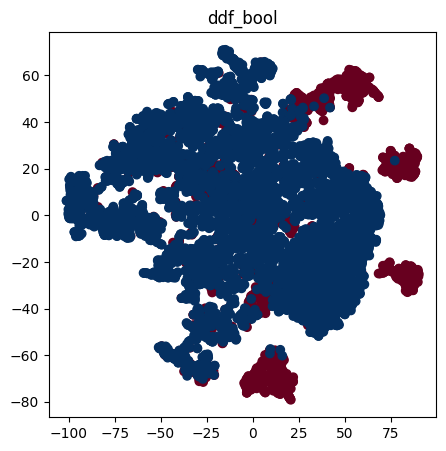

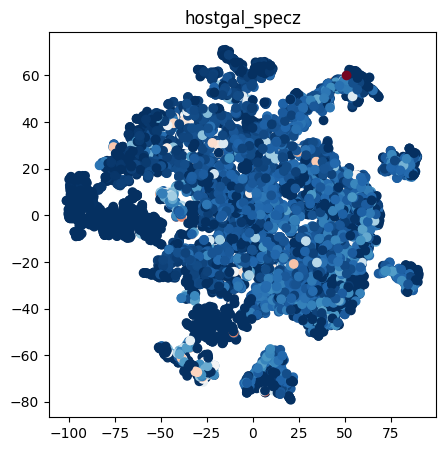

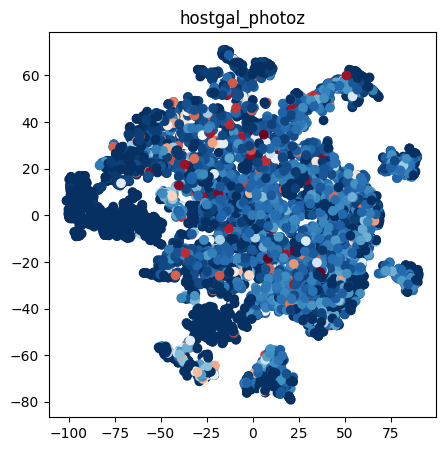

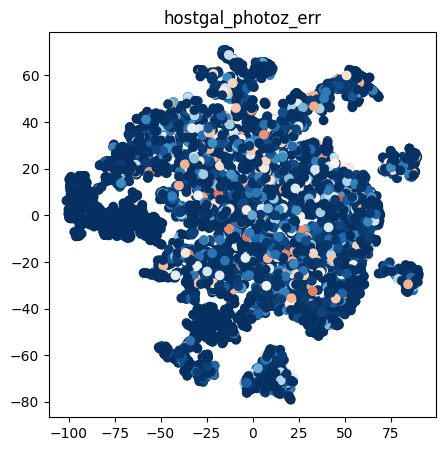

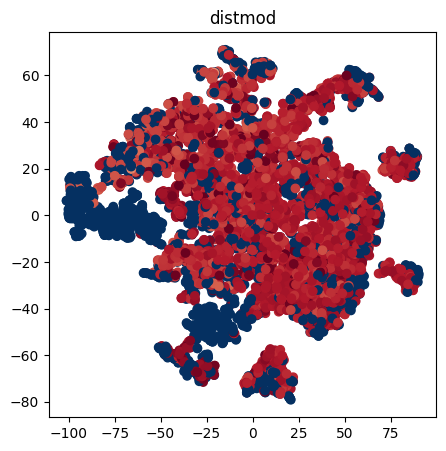

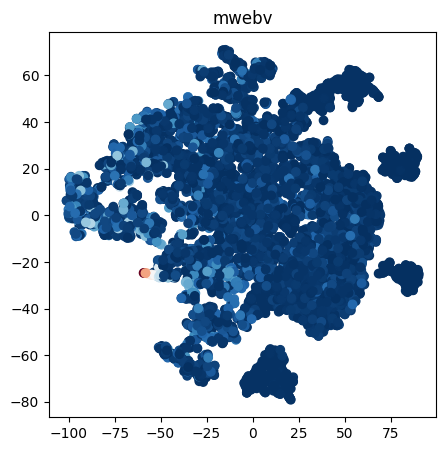

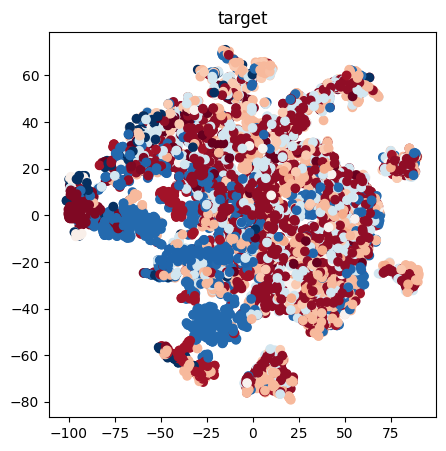

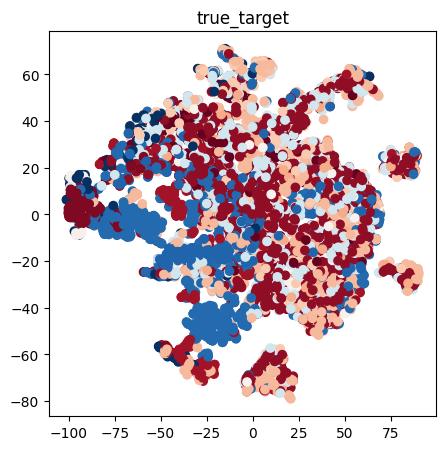

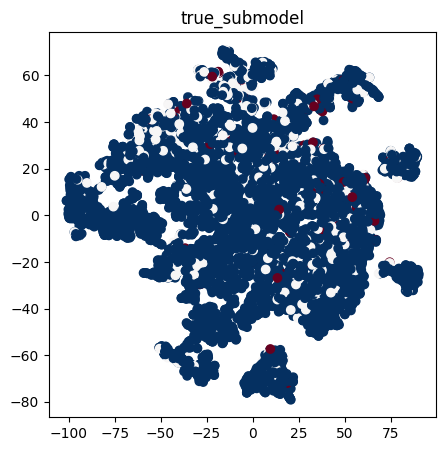

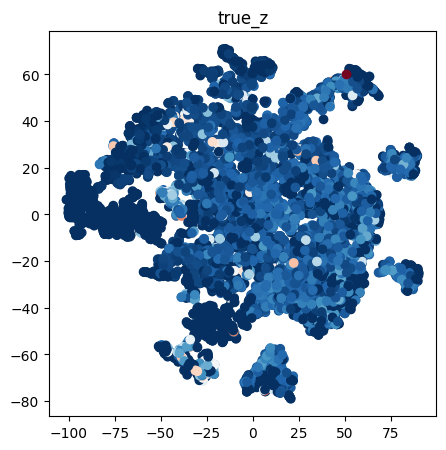

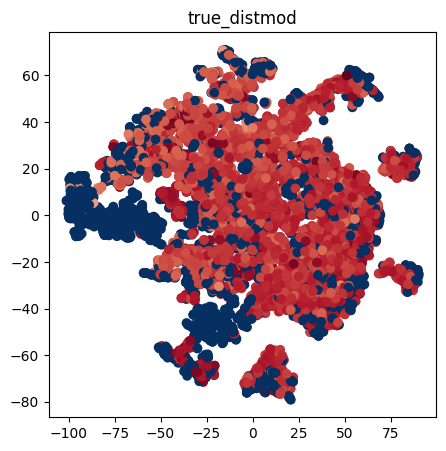

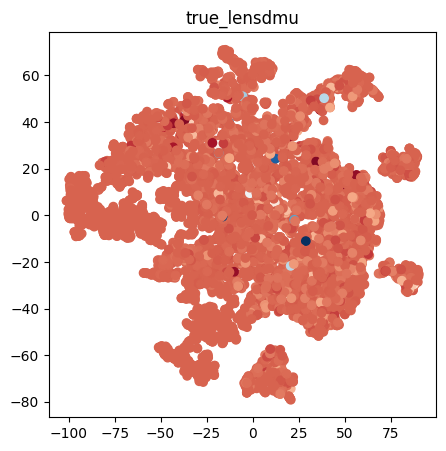

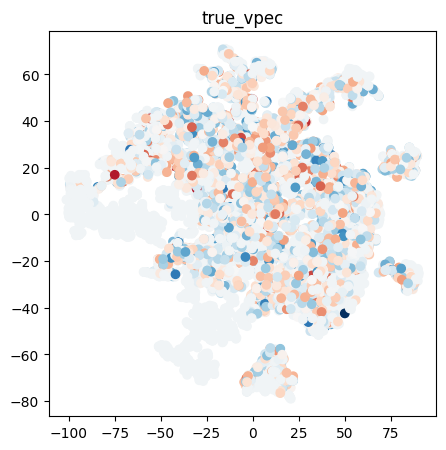

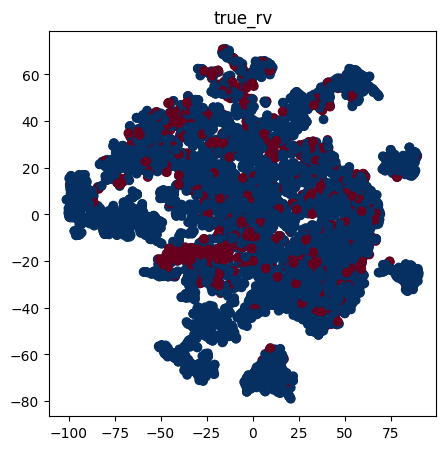

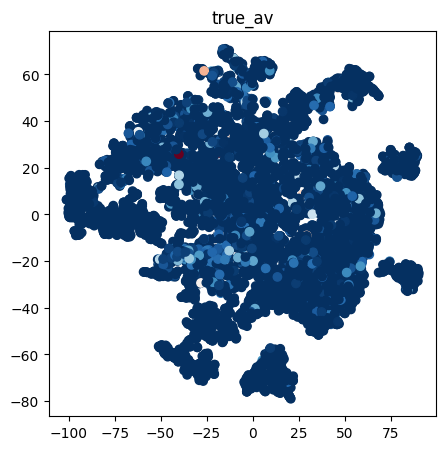

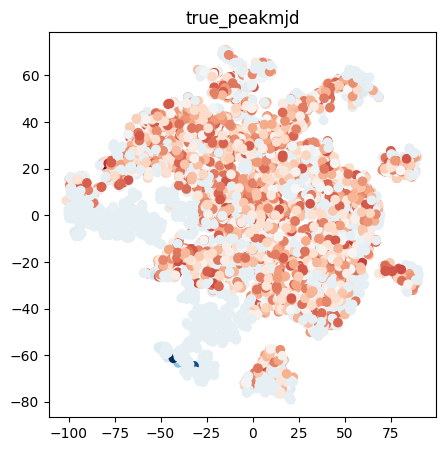

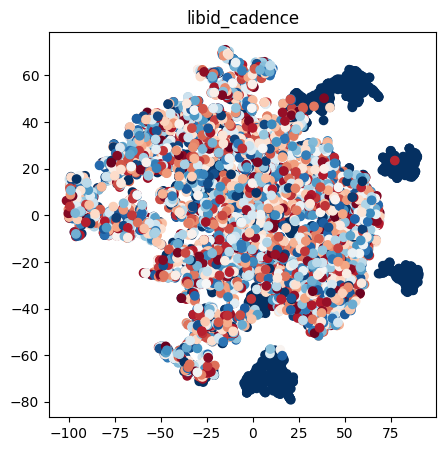

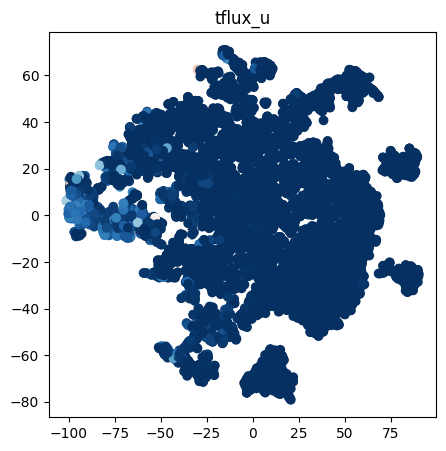

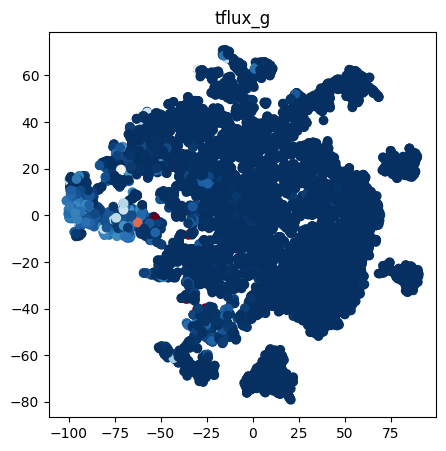

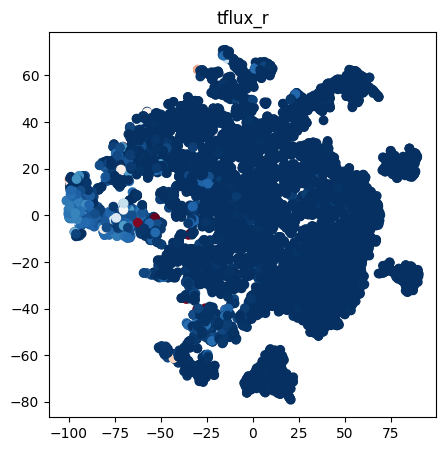

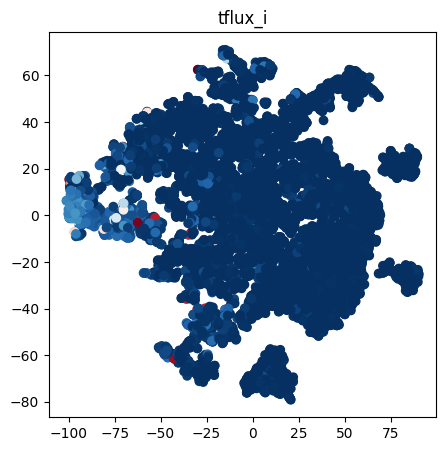

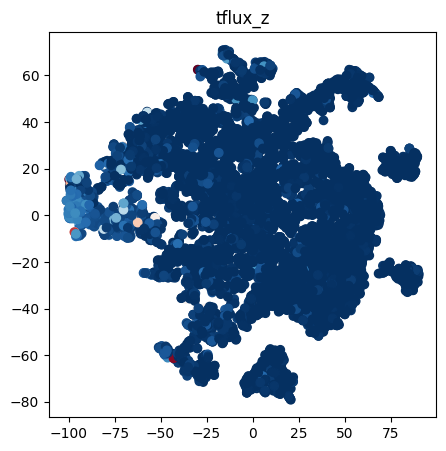

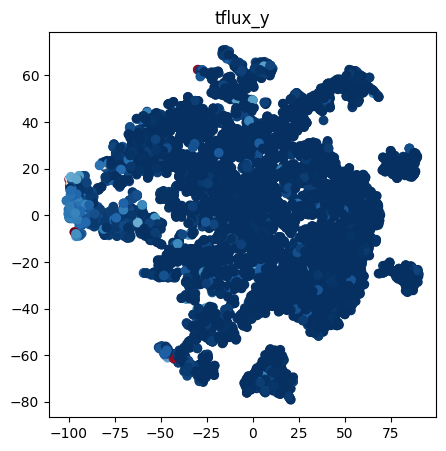

In [355]:
for col in metadata.columns:
    v = metadata[col].astype(float)
    pl.figure(figsize=(5,5))
    pl.title(col)
    pl.scatter(X_embedded[:,0], X_embedded[:,1],  color=[pl.cm.RdBu_r(Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])
    pl.show()